In [2]:
!pip install lightgbm

1. 자전거 데이터에서 "casual" (즉흥적인 회원 대여수), "registered" (일상 회원 대여수)를 
y로 예측하는 Linear regression, LGBM 모델을 각각 만들고 예측 성능을 비교하세요.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 584, number of used features: 14
[LightGBM] [Info] Start training from score 820.258562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

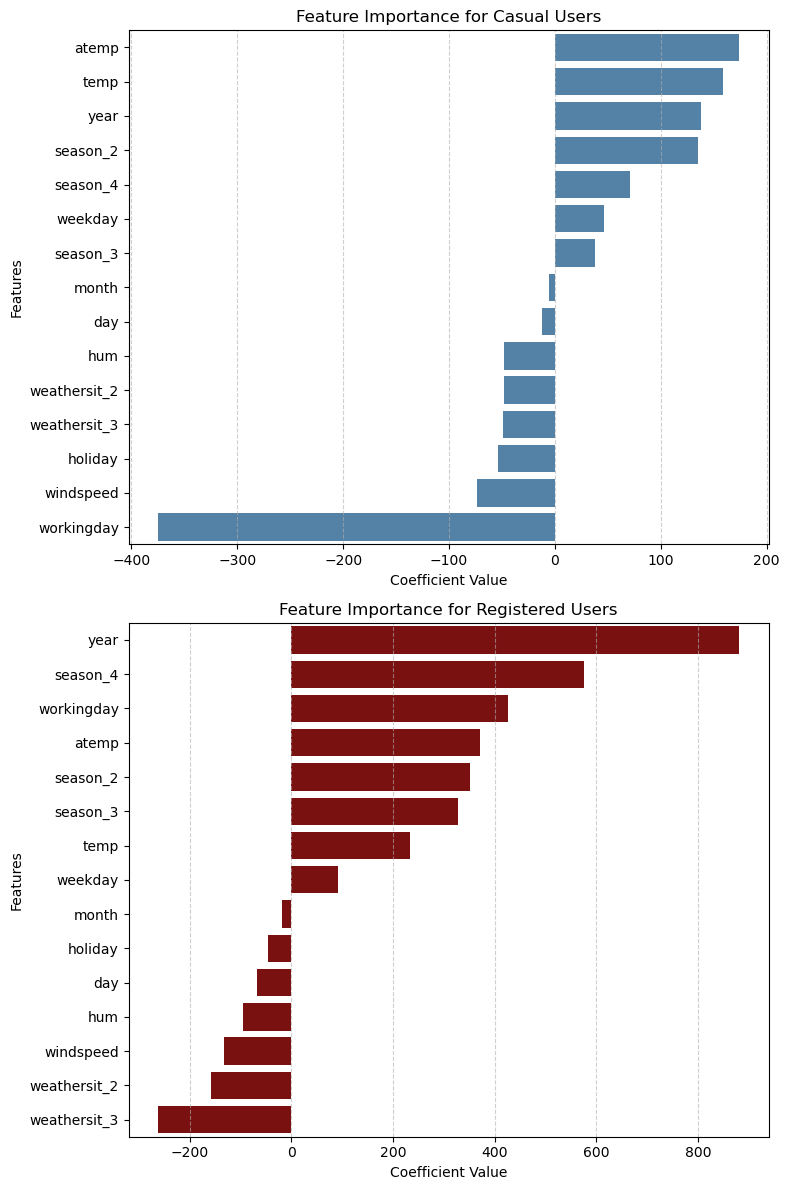

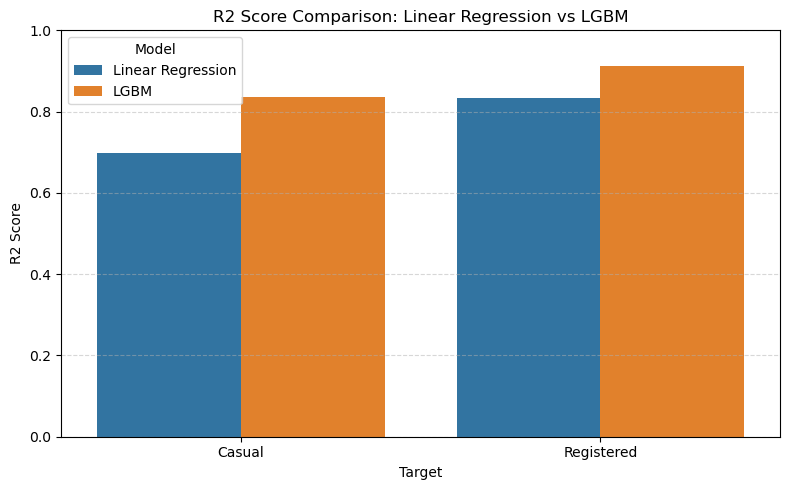

,Target,Model,R2 Score
0,Casual,Linear Regression,0.696995
1,Casual,LGBM,0.836301
2,Registered,Linear Regression,0.833079
3,Registered,LGBM,0.912489


In [3]:
# 필요한 라이브러리 다시 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor

# 파일 재업로드 필요
file_path = r"C:\001. Python\700. 설명가능인공지능_실습\bike-sharing-daily.csv"

# 데이터 로드
df_bike = pd.read_csv(file_path, engine="python", encoding="utf-8")

# 날짜 데이터 처리 (연, 월, 일 분리)
df_bike["dteday"] = pd.to_datetime(df_bike["dteday"])
df_bike["year"] = df_bike["dteday"].dt.year
df_bike["month"] = df_bike["dteday"].dt.month
df_bike["day"] = df_bike["dteday"].dt.day

# 불필요한 원래 날짜 컬럼 삭제
df_bike.drop(columns=["dteday", "instant"], inplace=True)

# 범주형 변수 인코딩 (one-hot encoding)
df_bike = pd.get_dummies(df_bike, columns=['season', 'weathersit'], drop_first=True)

# 다중 공선성을 방지하기 위해 'yr', 'mnth' 제거 (연도는 'year', 월은 'month' 사용)
df_bike.drop(columns=["yr", "mnth"], inplace=True)

# 독립변수 X 설정
x_bike = df_bike.drop(columns=['casual', 'registered', 'cnt'])

# 데이터 스케일링 (표준화)
scaler = StandardScaler()
x_bike_scaled = pd.DataFrame(scaler.fit_transform(x_bike), columns=x_bike.columns)

# casual (즉흥적 대여) 예측 모델
y_casual = df_bike['casual']
x_train_casual, x_test_casual, y_train_casual, y_test_casual = train_test_split(x_bike_scaled, y_casual, test_size=0.2, random_state=10)

lr_casual = LinearRegression()
lr_casual.fit(x_train_casual, y_train_casual)
pred_casual = lr_casual.predict(x_test_casual)
r2_casual = r2_score(y_test_casual, pred_casual)

coef_casual = pd.Series(lr_casual.coef_, index=x_bike_scaled.columns).sort_values(ascending=False)

# registered (등록된 회원 대여) 예측 모델
y_registered = df_bike['registered']
x_train_registered, x_test_registered, y_train_registered, y_test_registered = train_test_split(x_bike_scaled, y_registered, test_size=0.2, random_state=10)

lr_registered = LinearRegression()
lr_registered.fit(x_train_registered, y_train_registered)
pred_registered = lr_registered.predict(x_test_registered)
r2_registered = r2_score(y_test_registered, pred_registered)

coef_registered = pd.Series(lr_registered.coef_, index=x_bike_scaled.columns).sort_values(ascending=False)

# ----------- LGBM 모델 학습 및 평가 -----------

# casual 예측 - LGBM
lgbm_casual = LGBMRegressor(random_state=10)
lgbm_casual.fit(x_train_casual, y_train_casual)
pred_lgbm_casual = lgbm_casual.predict(x_test_casual)
r2_lgbm_casual = r2_score(y_test_casual, pred_lgbm_casual)

# registered 예측 - LGBM
lgbm_registered = LGBMRegressor(random_state=10)
lgbm_registered.fit(x_train_registered, y_train_registered)
pred_lgbm_registered = lgbm_registered.predict(x_test_registered)
r2_lgbm_registered = r2_score(y_test_registered, pred_lgbm_registered)

# 모델 성능 비교
r2_results = pd.DataFrame({
    "Model": ["Casual", "Registered"],
    "R2 Score": [r2_casual, r2_registered]
})

# 시각화
fig, axes = plt.subplots(2, 1, figsize=(8, 12))

sns.barplot(x=coef_casual.values, y=coef_casual.index, ax=axes[0], color="steelblue")
axes[0].set_title("Feature Importance for Casual Users")
axes[0].set_xlabel("Coefficient Value")
axes[0].set_ylabel("Features")
axes[0].grid(axis='x', linestyle="--", alpha=0.6)

sns.barplot(x=coef_registered.values, y=coef_registered.index, ax=axes[1], color="darkred")
axes[1].set_title("Feature Importance for Registered Users")
axes[1].set_xlabel("Coefficient Value")
axes[1].set_ylabel("Features")
axes[1].grid(axis='x', linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

# 결과 출력 (모델 성능 및 회귀 계수)
# season은 1 (Winter), 2 (Spring), 3 (Summer), 4 (Fall), weathersit는 1 (Good), 2 (Misty), 3(Rain/Snow/Storm)
r2_results, coef_casual, coef_registered

# ----------- 성능 비교 -----------

r2_comparison = pd.DataFrame({
    "Target": ["Casual", "Casual", "Registered", "Registered"],
    "Model": ["Linear Regression", "LGBM", "Linear Regression", "LGBM"],
    "R2 Score": [r2_casual, r2_lgbm_casual, r2_registered, r2_lgbm_registered]
})

# ----------- 시각화 -----------

plt.figure(figsize=(8, 5))
sns.barplot(data=r2_comparison, x="Target", y="R2 Score", hue="Model")
plt.title("R2 Score Comparison: Linear Regression vs LGBM")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# ----------- 결과 출력 -----------

r2_comparison

